In [1]:
import sys

from importlib import reload

import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)s | %(name)s | %(levelname)s : %(message)s',
    level=logging.INFO,
    stream=sys.stdout
)

logger = logging.getLogger('hysped')
logger.setLevel(logging.DEBUG)

import keras
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import zipfile

from IPython.display import JSON, HTML
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers
from tqdm.notebook import trange, tqdm

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
cfg = {
    'data_dir': os.path.join('..', 'data'),
    # 'data': 'sverepec_24.zip'
    'data': 'hysped_integrovane_redukovane.zip'
}
display(JSON(cfg))

<IPython.core.display.JSON object>

In [3]:
def split_df(df:pd.DataFrame, split:float=0.7) -> pd.DataFrame:
    rows = df.shape[0]
    at = int(split * rows)
    return df[:at], df[at:]

def nsplit_df(df:pd.DataFrame, splits:[float]=[0.7]) -> pd.DataFrame:
    rows = df.shape[0]
    df_splits = []
    beg = 0
    for split in splits:
        at = int(split * rows)
        df_splits.append(df[beg:at])
        beg = at
    df_splits.append(df[beg:])
    return df_splits

# Analyze data

In [4]:
filename = os.path.join(cfg['data_dir'], cfg['data'])
df = pd.read_csv(filename)

display(HTML('<h2>Data preview:</h2>'))
display(df)
display(HTML('<hr>'))
display(HTML('<h2>Data statistics:</h2>'))
display(df.describe())

,b1_12_10_2,b2_12_10_2,b3_12_10_2,b4_12_10_2,b5_12_10_2,b6_12_10_2,b7_12_10_2,b8_12_10_2,b9_12_10_2,b10_12_10_,...,b468_12_10,b469_12_10,b470_12_10,b471_12_10,b472_12_10,b473_12_10,b474_12_10,DRUH_DR,IDFULL,IDPL
0,0.002312,0.002194,0.002344,0.002613,0.002497,0.002717,0.002706,0.002898,0.002586,0.003052,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,CR,3-48,3
1,0.002277,0.002337,0.002361,0.002488,0.002334,0.002713,0.002796,0.002779,0.002748,0.003034,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,CR,3-48,3
2,0.002243,0.002479,0.002402,0.002322,0.002627,0.002943,0.002809,0.002854,0.002725,0.003096,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,CR,3-48,3
3,0.001883,0.002045,0.002057,0.001970,0.002191,0.002052,0.002102,0.001991,0.001920,0.002308,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,CR,3-48,3
4,0.002193,0.001915,0.002164,0.002090,0.002031,0.002108,0.002084,0.002123,0.001950,0.002291,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,CR,3-48,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96434,0.002469,0.002863,0.003135,0.003027,0.003056,0.003230,0.003328,0.003523,0.003396,0.003746,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,BR,25-41,25
96435,0.001235,0.000966,0.000953,0.001050,0.000891,0.001143,0.000930,0.001075,0.000944,0.001074,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,BR,25-41,25
96436,0.001709,0.001565,0.001225,0.001534,0.001722,0.002060,0.001738,0.001615,0.001751,0.002011,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,BR,25-41,25
96437,0.001823,0.001716,0.001534,0.001772,0.001997,0.002358,0.002048,0.001988,0.001989,0.002377,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,BR,25-41,25


,b1_12_10_2,b2_12_10_2,b3_12_10_2,b4_12_10_2,b5_12_10_2,b6_12_10_2,b7_12_10_2,b8_12_10_2,b9_12_10_2,b10_12_10_,...,b466_12_10,b467_12_10,b468_12_10,b469_12_10,b470_12_10,b471_12_10,b472_12_10,b473_12_10,b474_12_10,IDPL
count,96439.000000,96439.000000,96439.000000,96439.000000,96439.000000,96439.000000,96439.000000,96439.000000,96439.000000,96439.000000,...,96439.000000,96439.000000,96439.000000,96439.000000,96439.000000,96439.000000,96439.000000,96439.000000,96439.000000,96439.000000
mean,0.002132,0.002183,0.002292,0.002417,0.002453,0.002524,0.002519,0.002466,0.002320,0.002745,...,-5754.150313,-5754.150313,-5754.150313,-5754.150313,-5754.150313,-5754.150313,-5754.150313,-5754.150313,-5754.150313,14.590352
std,0.000798,0.000838,0.000907,0.000970,0.001005,0.001051,0.001066,0.001064,0.001014,0.001227,...,4942.242045,4942.242045,4942.242045,4942.242045,4942.242045,4942.242045,4942.242045,4942.242045,4942.242045,9.737032
min,0.000369,0.000332,0.000345,0.000441,0.000444,0.000410,0.000456,0.000441,0.000372,0.000461,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,3.000000
25%,0.001515,0.001530,0.001576,0.001645,0.001653,0.001680,0.001660,0.001605,0.001488,0.001741,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,4.000000
50%,0.002038,0.002083,0.002188,0.002296,0.002338,0.002403,0.002400,0.002344,0.002209,0.002610,...,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,22.000000
75%,0.002630,0.002705,0.002859,0.003023,0.003084,0.003194,0.003205,0.003160,0.002989,0.003563,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.000000
max,0.008968,0.009530,0.009941,0.010524,0.010564,0.010553,0.010174,0.010079,0.009794,0.011296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.000000


In [5]:
print('columns (%d): %s' % (df.columns.shape[0], ', '.join(df.columns)))

columns (477): b1_12_10_2, b2_12_10_2, b3_12_10_2, b4_12_10_2, b5_12_10_2, b6_12_10_2, b7_12_10_2, b8_12_10_2, b9_12_10_2, b10_12_10_, b11_12_10_, b12_12_10_, b13_12_10_, b14_12_10_, b15_12_10_, b16_12_10_, b17_12_10_, b18_12_10_, b19_12_10_, b20_12_10_, b21_12_10_, b22_12_10_, b23_12_10_, b24_12_10_, b25_12_10_, b26_12_10_, b27_12_10_, b28_12_10_, b29_12_10_, b30_12_10_, b31_12_10_, b32_12_10_, b33_12_10_, b34_12_10_, b35_12_10_, b36_12_10_, b37_12_10_, b38_12_10_, b39_12_10_, b40_12_10_, b41_12_10_, b42_12_10_, b43_12_10_, b44_12_10_, b45_12_10_, b46_12_10_, b47_12_10_, b48_12_10_, b49_12_10_, b50_12_10_, b51_12_10_, b52_12_10_, b53_12_10_, b54_12_10_, b55_12_10_, b56_12_10_, b57_12_10_, b58_12_10_, b59_12_10_, b60_12_10_, b61_12_10_, b62_12_10_, b63_12_10_, b64_12_10_, b65_12_10_, b66_12_10_, b67_12_10_, b68_12_10_, b69_12_10_, b70_12_10_, b71_12_10_, b72_12_10_, b73_12_10_, b74_12_10_, b75_12_10_, b76_12_10_, b77_12_10_, b78_12_10_, b79_12_10_, b80_12_10_, b81_12_10_, b82_12_10_, b

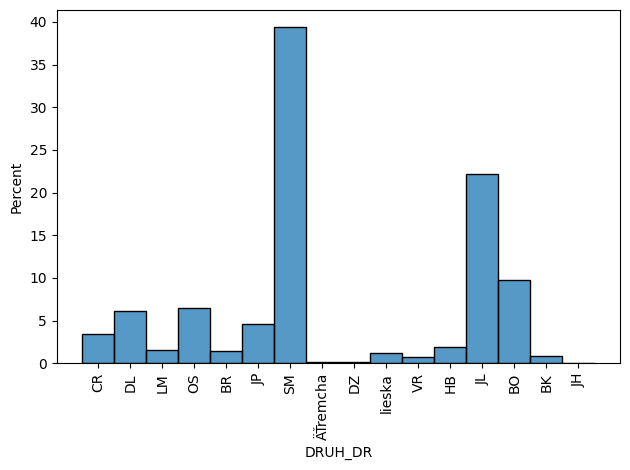

In [6]:
g = sns.histplot(df[df.DRUH_DR.name], stat='percent')
g.xaxis.set_major_locator(mticker.FixedLocator(g.get_xticks()))
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

## Plot a selected feature

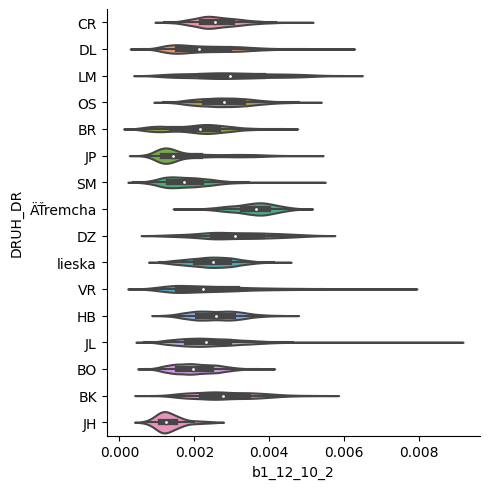

In [38]:
sns.catplot(data=df, x='b1_12_10_2', y='DRUH_DR', kind='violin')
plt.show()

## Plot densities of the first 20 hyperspectral features per each class

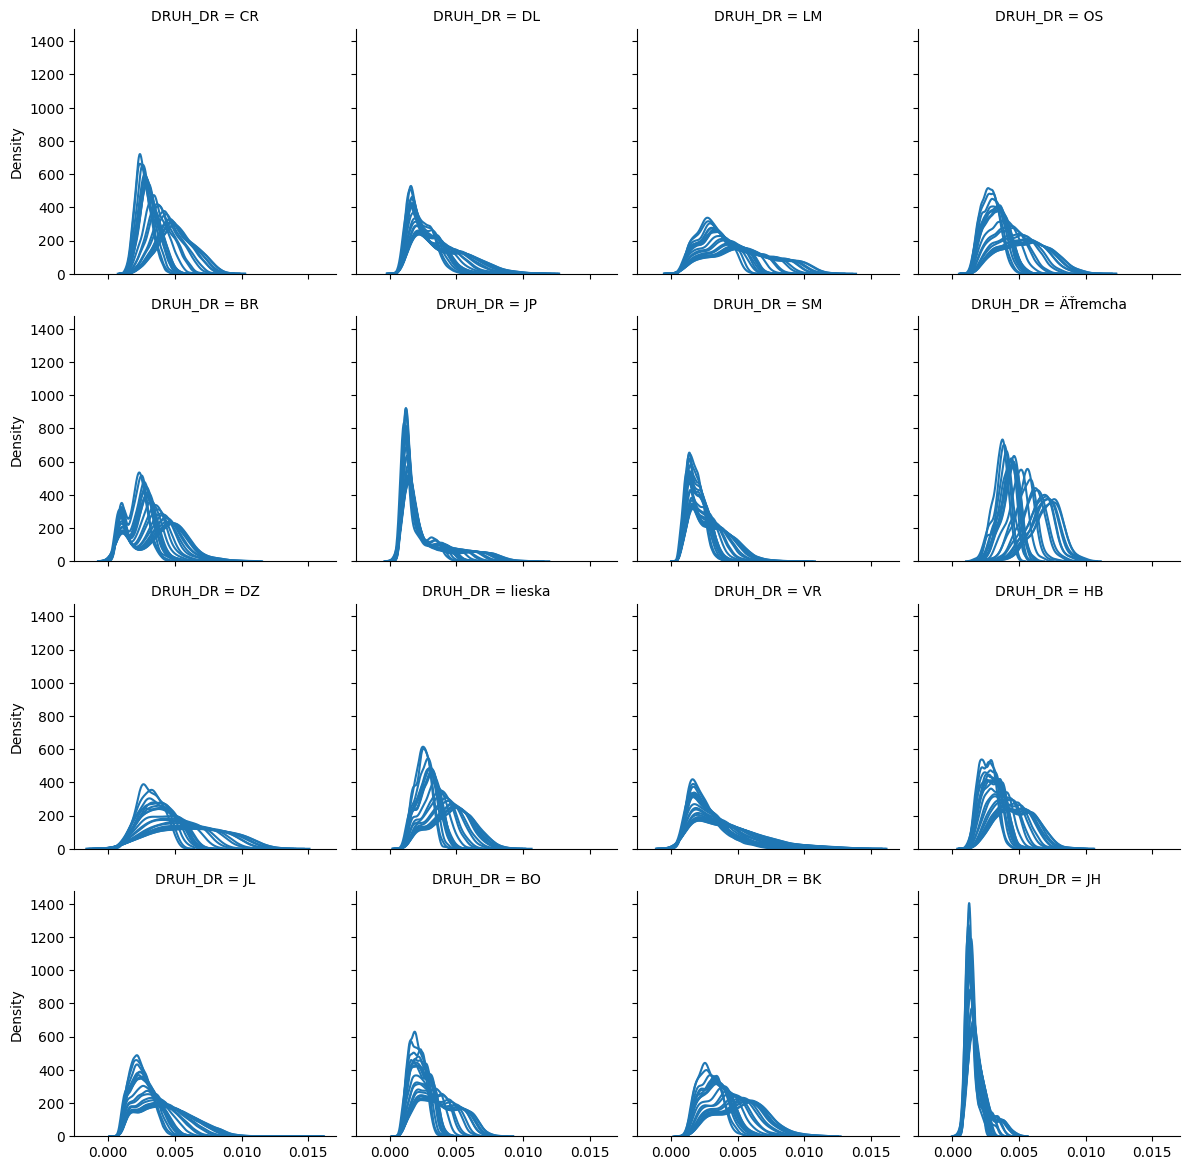

In [75]:
g = sns.FacetGrid(df, col="DRUH_DR", col_wrap=4)

# plot only features starting with 'b0, b1, ..., b9'
for col in enumerate(df.columns[df.columns.to_series().str.match(r'^b\d+.*')]):
    if col[0] < 20:
        gg = g.map(sns.kdeplot, col[1], label=col[1], warn_singular=False)
        gg.set_axis_labels(x_var='')

# g.add_legend()
plt.show()

## Sampling data

In [77]:
df_sample = df.sample(frac=0.1)

In [78]:
df_sample[df_sample.columns[df_sample.columns.to_series().str.match(r'^b\d+.*|DRUH_DR')]]

,b1_12_10_2,b2_12_10_2,b3_12_10_2,b4_12_10_2,b5_12_10_2,b6_12_10_2,b7_12_10_2,b8_12_10_2,b9_12_10_2,b10_12_10_,...,b466_12_10,b467_12_10,b468_12_10,b469_12_10,b470_12_10,b471_12_10,b472_12_10,b473_12_10,b474_12_10,DRUH_DR
71265,0.001690,0.002245,0.001937,0.002447,0.002050,0.002198,0.002100,0.002010,0.001936,0.002256,...,0,0,0,0,0,0,0,0,0,JL
82611,0.001279,0.001137,0.000992,0.000950,0.001083,0.001172,0.000970,0.001191,0.000990,0.001065,...,0,0,0,0,0,0,0,0,0,SM
24069,0.001044,0.001114,0.001205,0.001542,0.001447,0.001180,0.001264,0.001183,0.001163,0.001400,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,SM
32334,0.002567,0.002937,0.002937,0.002937,0.003223,0.003263,0.003376,0.003001,0.003096,0.003688,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,JL
11112,0.002472,0.002107,0.002280,0.002415,0.002626,0.002638,0.002720,0.002514,0.002351,0.002931,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,SM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33373,0.003634,0.003962,0.003965,0.004139,0.003748,0.004272,0.004619,0.004480,0.004299,0.004677,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,JL
31963,0.001408,0.001400,0.001539,0.001489,0.001505,0.001612,0.001342,0.001505,0.001499,0.001626,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,DL
83385,0.002794,0.002642,0.002563,0.002987,0.003093,0.003077,0.003061,0.003018,0.002747,0.003263,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,SM
64630,0.001411,0.001380,0.001579,0.001381,0.001392,0.001494,0.001500,0.001405,0.001219,0.001423,...,0,0,0,0,0,0,0,0,0,SM


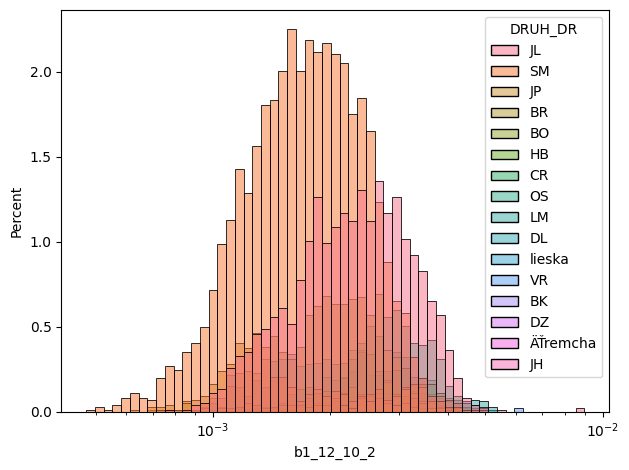

In [82]:
g = sns.histplot(data=df_sample, x='b1_12_10_2', hue='DRUH_DR', stat='percent', log_scale=True)
# g.xaxis.set_major_locator(mticker.FixedLocator(g.get_xticks()))
# g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

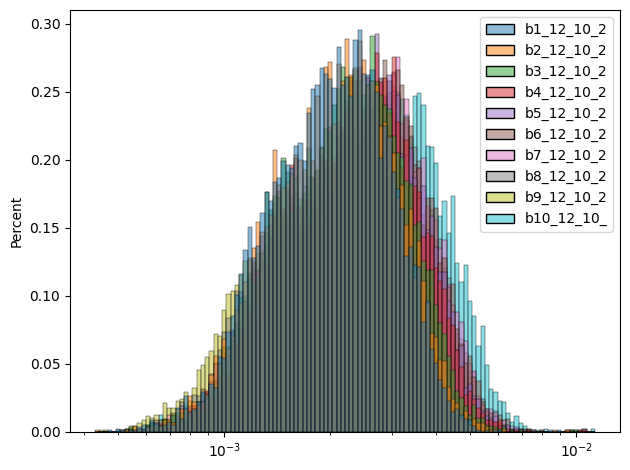

In [87]:
g = sns.histplot(df_sample[df_sample.columns[df_sample.columns.to_series().str.match(r'^b\d+.*')][0:10]], stat='percent', log_scale=True)
# g.xaxis.set_major_locator(mticker.FixedLocator(g.get_xticks()))
# g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

# Preprocess data and split it to FL sites

In [18]:
num_sites = 4

# data_dir = os.path.join('..', 'data')
# filename = os.path.join(data_dir, 'hysped_integrovane_redukovane.csv')
data_dir = os.path.join('..', 'data-sverepec_24')
filename = os.path.join(data_dir, 'sverepec_24.csv')

# data
logger.debug('loading data: %s' % filename)
df = pd.read_csv(filename)

# select columns
data_cols = df.columns[df.columns.to_series().str.match(r'b\d+(_\d+)+')]
label_col = df.DRUH_DR.name
all_cols = data_cols.append(pd.Index([label_col]))
logger.debug('selecting columns: %s' % all_cols.values)
df = df[all_cols]

# drop rows having at least 1 column na
df = df.dropna(axis=0, how='any')

# data cleaning - keep records with defined labels
df = df[~df.DRUH_DR.isna() & df.DRUH_DR.str.match(r'[A-Z]{2}|lieska')]

# # replace nan in labels
# df[label_col] = df[label_col].fillna('NaN')

# encode string labels
logger.debug('encoding labels: %s' % label_col)
label_encoder = LabelEncoder()
df[label_col] = label_encoder.fit_transform(df[label_col])

# save encoder
encoder_filename = os.path.join(data_dir, 'encoder-%s.npy' % label_col)
logger.debug('saving encoder: %s' % encoder_filename)
np.save(encoder_filename, label_encoder.classes_)
        
site_dfs = []
# randomly sample data into proportionally-sized sites and split it to train and test for each site
for i in trange(num_sites, desc='sampling site data'):

    # sample site data
    frac = 1 / (num_sites - i)
    site_df = df.sample(frac = frac)
    df = df.drop(site_df.index)

    # split site data to train and test
    site_df_train, site_df_test = split_df(site_df, split=0.7)

    site = i + 1  
    site_dir = os.path.join(data_dir, 'site-%d' % site)
    if not os.path.isdir(site_dir):
        os.mkdir(site_dir)
       
    # make symlink to label encoder
    symlink = os.path.join(site_dir, os.path.basename(encoder_filename))
    if not os.path.exists(symlink):
        os.link(encoder_filename, symlink)
    
    site_df_train.to_csv(os.path.join(site_dir, 'train.csv'), index=False)
    site_df_test.to_csv(os.path.join(site_dir, 'test.csv'), index=False)

2023-03-08 13:32:47,194 | hysped | DEBUG : loading data: ../data-sverepec_24/sverepec_24.csv
2023-03-08 13:32:47,491 | hysped | DEBUG : selecting columns: ['b1_12_10_2' 'b2_12_10_2' 'b3_12_10_2' 'b4_12_10_2' 'b5_12_10_2'
 'b6_12_10_2' 'b7_12_10_2' 'b8_12_10_2' 'b9_12_10_2' 'b10_12_10_'
 'b11_12_10_' 'b12_12_10_' 'b13_12_10_' 'b14_12_10_' 'b15_12_10_'
 'b16_12_10_' 'b17_12_10_' 'b18_12_10_' 'b19_12_10_' 'b20_12_10_'
 'b21_12_10_' 'b22_12_10_' 'b23_12_10_' 'b24_12_10_' 'b25_12_10_'
 'b26_12_10_' 'b27_12_10_' 'b28_12_10_' 'b29_12_10_' 'b30_12_10_'
 'b31_12_10_' 'b32_12_10_' 'b33_12_10_' 'b34_12_10_' 'b35_12_10_'
 'b36_12_10_' 'b37_12_10_' 'b38_12_10_' 'b39_12_10_' 'b40_12_10_'
 'b41_12_10_' 'b42_12_10_' 'b43_12_10_' 'b44_12_10_' 'b45_12_10_'
 'b46_12_10_' 'b47_12_10_' 'b48_12_10_' 'b49_12_10_' 'b50_12_10_'
 'b51_12_10_' 'b52_12_10_' 'b53_12_10_' 'b54_12_10_' 'b55_12_10_'
 'b56_12_10_' 'b57_12_10_' 'b58_12_10_' 'b59_12_10_' 'b60_12_10_'
 'b61_12_10_' 'b62_12_10_' 'b63_12_10_' 'b64_12_10_' 

sampling site data:   0%|          | 0/4 [00:00<?, ?it/s]

In [82]:
site_df_train.shape

(16848, 475)

In [83]:
data_dir = os.path.join('..', 'data')
label_encoder_filename = os.path.join(data_dir, 'encoder-DRUH_DR.npy')
np.load(label_encoder_filename, allow_pickle=True)

array(['BK', 'BO', 'BR', 'CR', 'DL', 'DZ', 'HB', 'JH', 'JL', 'JP', 'LM',
       'OS', 'SM', 'VR', 'lieska'], dtype=object)